In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline 

In [19]:
data = pd.read_csv('a1_dataset.csv')
data = data.drop(['var7'], axis = 1)
data.shape

(925, 7)

# Preprocessing

## Encoding

In [20]:
features_name = ['var3', 'var6']
len(pd.unique(data['var3']))

236

### OneHot Encoding

I decided to use Ordinal encoding for *var3* and *va6*. 

As we disscussed on lab: For categorical variables where ordinal relationship exists, we use Ordinal encoding. 
Therefore, it seems that it is better to use the OneHot encoding. 
But in this task we have 236 unique countries in column *var3*. 
Therefore, when we use OneHot encoding, our data contains 241 features. 
On this amount of features it is hard/impossible to use polynomial regression with degree more than 2.

In addition, I tried both Ordinal and OneHot encoders. For Ordinal encoding linear regression has error less than for OneHot regression.

In [21]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

new_feats = encoder.fit_transform(data[features_name])
new_cols = pd.DataFrame(new_feats, dtype=int, columns=features_name)
new_data = data.drop(features_name, axis=1)
new_data = pd.concat([new_data, new_cols], axis=1)
new_data


,target,var1,var2,var4,var5,var3,var6
0,0,509.18,417.681,138.0,393.00,137,0
1,0,446.06,666.182,81.0,352.05,57,1
2,1,235.50,398.097,90.0,339.00,101,0
3,0,306.02,518.163,102.0,439.25,216,1
4,0,453.08,600.156,105.0,422.95,36,0
...,...,...,...,...,...,...,...
920,0,422.34,547.259,NaN,350.45,19,1
921,1,342.62,473.919,NaN,200.85,105,0
922,1,265.10,538.170,NaN,208.35,179,1
923,0,397.12,622.386,NaN,433.45,41,1


## Data Imputation

In [22]:
data_var4 = new_data[new_data['var4'].notna()]
predict_data_var4 = new_data[new_data['var4'].isna()]

print('Testing:', predict_data_var4.shape, 'Training:', data_var4.shape)

Testing: (600, 7) Training: (325, 7)


### Linear regression

In [23]:
from sklearn.model_selection import train_test_split

X_predict = pd.concat([predict_data_var4.loc[:, :'var2'], 
                       predict_data_var4.loc[:, 'var5':]], 
                       axis=1)

X = pd.concat([data_var4.loc[:, :'var2'], 
               data_var4.loc[:, 'var5':]], 
               axis=1)
y = data_var4['var4']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

In [25]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 16.852377860135828
Mean Squared Error: 466.22346114902194
Root Mean Squared Error: 21.592208343497937


### Polynomial regression

In [26]:
degrees = [i for i in range(2, 10)]

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

mae_to_plot = []
mse_to_plot = []
rmse_to_plot = []

for i in degrees:
    polynomial_features = PolynomialFeatures(degree=i)
    linear_regression = LinearRegression()
    regressor = Pipeline([("polynomial_features", polynomial_features),
                          ("linear_regression", linear_regression)])
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    mae_to_plot.append(metrics.mean_absolute_error(y_test, y_pred))
    mse_to_plot.append(metrics.mean_squared_error(y_test, y_pred))
    rmse_to_plot.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

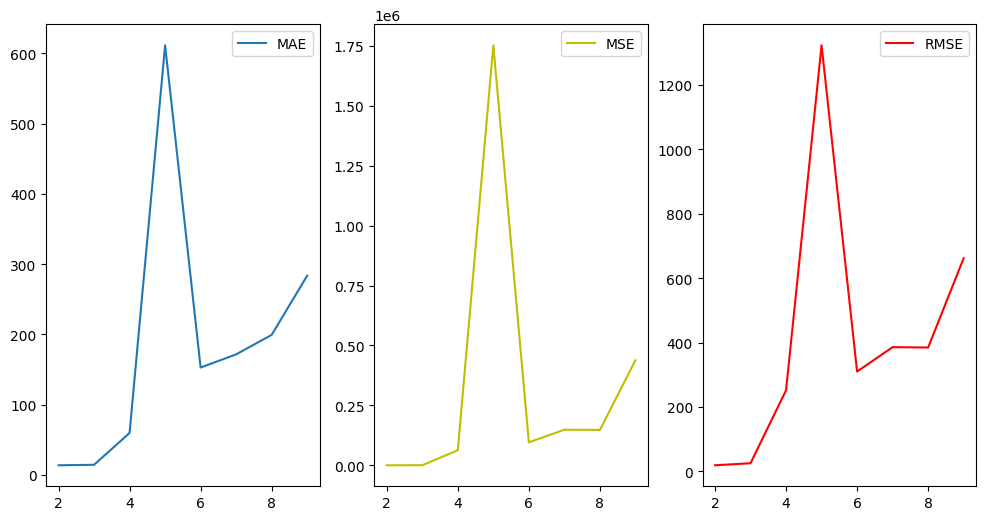

[13.899461298722487, 14.583135535787019, 59.84411592998535, 611.3977599842129, 152.93881372428487, 171.68460546533225, 199.4223919316014, 283.66295030062304]
[340.8565146505334, 615.6856531299427, 63199.33668435515, 1752099.5786883014, 95953.74157175698, 148643.8589572711, 147754.87303382097, 438276.3454207375]
[18.46229982018853, 24.81301378571218, 251.39478253208668, 1323.668983805355, 309.76400948424754, 385.5435889199444, 384.38896060347645, 662.0244296253255]


In [28]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

ax1.plot(degrees, mae_to_plot, label='MAE')
ax2.plot(degrees, mse_to_plot, label='MSE', c='y')
ax3.plot(degrees, rmse_to_plot, label='RMSE', c='r')

ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

print(mae_to_plot)
print(mse_to_plot)
print(rmse_to_plot)

### Find the missing values of *var4*

According to errors, it is better to use polynomial regression of the second degree to predict *var4*

In [29]:
polynomial_features = PolynomialFeatures(degree=2)
regressor = Pipeline([("polynomial_features", polynomial_features),
                      ("linear_regression", linear_regression)])
regressor.fit(X, y)
y_predict = regressor.predict(X_predict)

X['var4'] = y
X_predict['var4'] = y_predict

preprocessed_data = pd.concat([X, X_predict], axis=0)
preprocessed_data

,target,var1,var2,var5,var3,var6,var4
0,0,509.18,417.681,393.00,137,0,138.000000
1,0,446.06,666.182,352.05,57,1,81.000000
2,1,235.50,398.097,339.00,101,0,90.000000
3,0,306.02,518.163,439.25,216,1,102.000000
4,0,453.08,600.156,422.95,36,0,105.000000
...,...,...,...,...,...,...,...
920,0,422.34,547.259,350.45,19,1,36.738411
921,1,342.62,473.919,200.85,105,0,138.343895
922,1,265.10,538.170,208.35,179,1,133.485252
923,0,397.12,622.386,433.45,41,1,134.249771


## Implementing the PCA

### Data scaling

As we discussed on labs - PCA is sensitive to scaling. Therefore, I scale data using StandardScaler.

In [30]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
scaled_data = standard_scaler.fit_transform(preprocessed_data)
scaled_data = pd.DataFrame(scaled_data, 
                           columns=preprocessed_data.columns)

### PCA

In [31]:
# My PCA class
class PCA:
    dim : int
    good_eig_v : np.ndarray
    bad_eig_v : np.ndarray


    def __init__(self, dim):
        self.dim = dim

    # Function that transforms given data using good eigenvectors
    def transform(self, to_pca_data):
        return np.dot(to_pca_data.values, self.good_eig_v)

    # Function that transforms given data using bad eigenvectors
    def bad_transform(self, to_pca_data):
        return np.dot(to_pca_data.values, self.bad_eig_v)

    # Function to fit given data and calculate best eigenvectors for use
    def fit(self, to_pca_data, plot_eginvalues=False, print_eigenvectors=False):
        # Calculate covariance
        cov = np.cov(scaled_data.T)

        # Get eigenvalues and eigenvectors
        w, v = np.linalg.eig(cov)

        if self.dim > len(v):
            raise Exception('Given dimension is more than initial dimension')
        if self.dim < 1:
            raise Exception('Given dimension is less than 1')

        if plot_eginvalues:
            plt.bar([i+1 for i in range(len(w))], w)
            plt.title("Eigenvalues")
            plt.xlabel("Magnitude of the eigenvalue")
            plt.show()

        column_names = [f'v{i+1}' for i in range(len(v))]

        # Represent eigenvectors as dataframe
        v = pd.DataFrame(v, columns=column_names)
        if print_eigenvectors:
            print(v)

        sorted_names = [i for _, i in sorted(zip(w, column_names), reverse=True)]
        self.good_eig_v = v[sorted_names[:self.dim]].values
        self.bad_eig_v = v[sorted_names[-self.dim:]].values
        
        return self

According to eigenvalues - we need to take the first and the sixth eigenvectors to get the best result

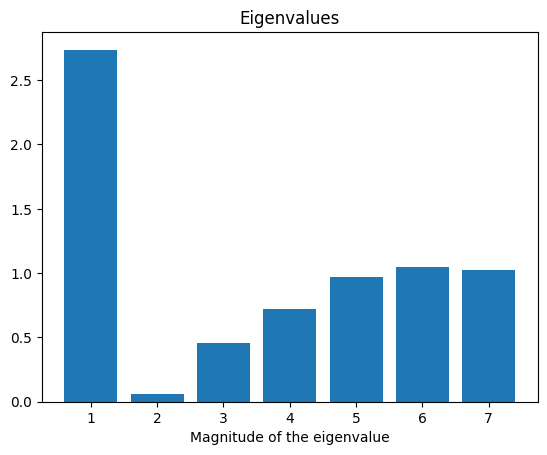

In [36]:
# Initialize my PCA object and fit it
pca = PCA(2)
pca.fit(scaled_data, plot_eginvalues=True)

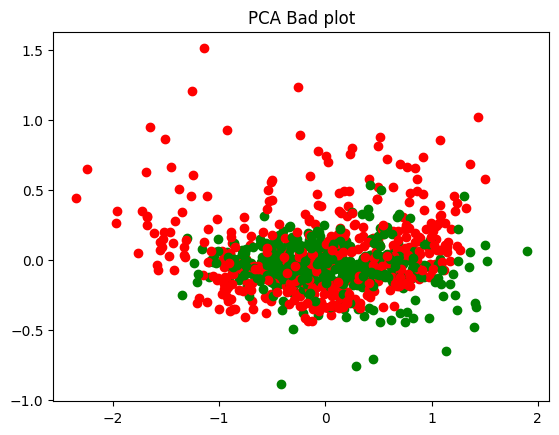

In [33]:
# Use eigenvectors with the smallest eigenvalues for pca
x_bad = pca.bad_transform(scaled_data)

# Plot data
color = ['g', 'r']
for i in range(len(x_bad)):
    x_temp = x_bad[i, 0]
    y_temp = x_bad[i, 1]
    c_temp = color[data['target'][i]]
    plt.plot(x_temp, y_temp, 'o', c=c_temp)

plt.title("PCA Bad plot")
plt.show()

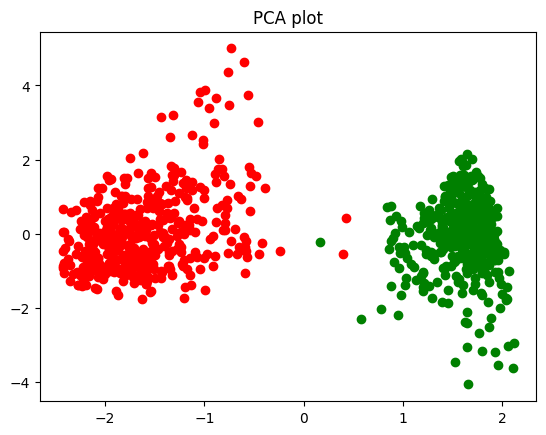

In [34]:
# Use eigenvectors with the highest eigenvalues for pca
x_pca = pca.transform(scaled_data)

# Plot data
for i in range(len(x_pca)):
    x_temp = x_pca[i, 0]
    y_temp = x_pca[i, 1]
    c_temp = color[data['target'][i]]
    plt.plot(x_temp, y_temp, 'o', c=c_temp)

plt.title("PCA plot")
plt.show()

# Training

Firstly, we need to split preprocessed data on training and testing

In [35]:
# Split data to target and features
X = preprocessed_data.iloc[:, 1:]
y = preprocessed_data['target']

# Split data to training and testing
random_state = 13
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=random_state, 
                                                    shuffle=True)

In [ ]:
# Scale testing and training data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), 
                       columns=X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_test), 
                      columns=X_test.columns)

## Logistic Regression